## Подключаю библиотеки

In [1]:
import numpy as np 
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from pandas import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import itertools
import warnings
import pmdarima as pm
from scipy import stats
import statsmodels.api as sm
from pmdarima.arima.utils import ndiffs

## Функции, которые будут использованы в дальнейшем 

In [2]:
def parser(x):
    return datetime.strptime(x,'%Y-%m-%dT%X')

In [3]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test1)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

## Загрузка и редактирование данных

In [4]:
traffic = pd.read_csv('trafficData158505.csv', parse_dates=[5], date_parser=parser)

In [5]:
traffic = traffic.drop(columns='status')
traffic = traffic.drop(columns='extID')
traffic = traffic.drop(columns='medianMeasuredTime')
traffic = traffic.drop(columns='_id')
traffic = traffic.drop(columns='REPORT_ID')

In [6]:
traffic = traffic.rename(columns={'TIMESTAMP': 'Дата','avgMeasuredTime': 'Среднее время', 'avgSpeed': 'Средняя скорость','vehicleCount':'Кол-во машин'})

In [7]:
new_traffic = traffic.iloc[:-16854]

In [8]:
new_traffic.head()

,Среднее время,Средняя скорость,Дата,Кол-во машин
0,141,52,2014-08-01 07:50:00,1
1,141,52,2014-08-01 07:55:00,0
2,119,62,2014-08-01 08:00:00,1
3,119,62,2014-08-01 08:05:00,1
4,119,62,2014-08-01 08:10:00,1


In [9]:
new_traffic.tail()

,Среднее время,Средняя скорость,Дата,Кол-во машин
95,133,55,2014-08-01 15:45:00,1
96,104,71,2014-08-01 15:50:00,1
97,104,71,2014-08-01 15:55:00,1
98,104,71,2014-08-01 16:00:00,0
99,109,68,2014-08-01 16:05:00,1


In [10]:
new_traffic.shape

(100, 4)

## Исходные данные характеристик транспортного потока

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


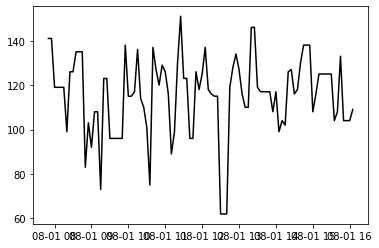

In [11]:
plt.plot(new_traffic['Дата'], new_traffic['Среднее время'], color='black')

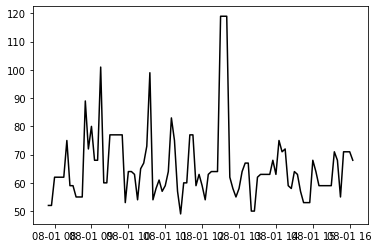

In [12]:
plt.plot(new_traffic['Дата'], new_traffic['Средняя скорость'], color = 'black')

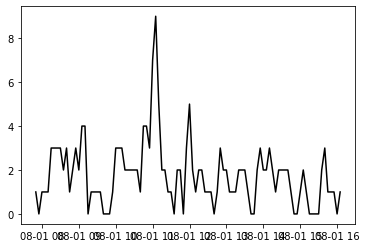

In [13]:
plt.plot(new_traffic['Дата'], new_traffic['Кол-во машин'], color = 'black')

## Предсказания с использованием ARIMA 

#### Среднее время 

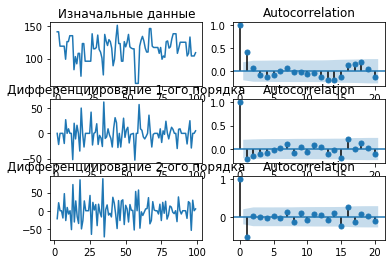

In [14]:
X = new_traffic['Среднее время']

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(X); axes[0, 0].set_title('Изначальные данные')
plot_acf(X, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(X.diff()); axes[1, 0].set_title('Дифференциирование 1-ого порядка')
plot_acf(X.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(X.diff().diff()); axes[2, 0].set_title('Дифференциирование 2-ого порядка')
plot_acf(X.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [15]:
model = ARIMA(X, order=(13,1,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.Среднее время   No. Observations:                   99
Model:                ARIMA(13, 1, 3)   Log Likelihood                -410.385
Method:                       css-mle   S.D. of innovations             14.433
Date:                Fri, 12 Jul 2019   AIC                            856.770
Time:                        17:56:40   BIC                            903.482
Sample:                             1   HQIC                           875.669
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0424      0.074      0.577      0.566      -0.102       0.187
ar.L1.D.Среднее время     -1.1465      0.101    -11.298      0.000      -1.345      -0.948
ar.L

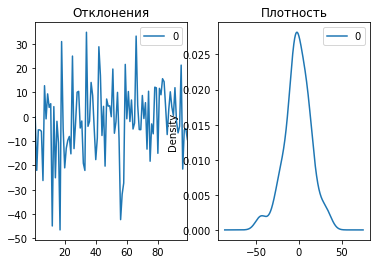

In [16]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Отклонения", ax=ax[0])
residuals.plot(kind='kde', title='Плотность', ax=ax[1])
plt.show()

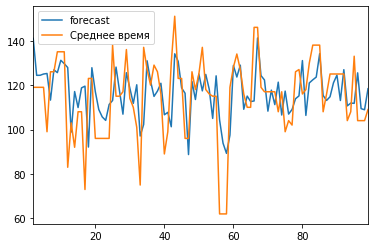

In [17]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [18]:
train1 = X[:80]
test1 = X[80:]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


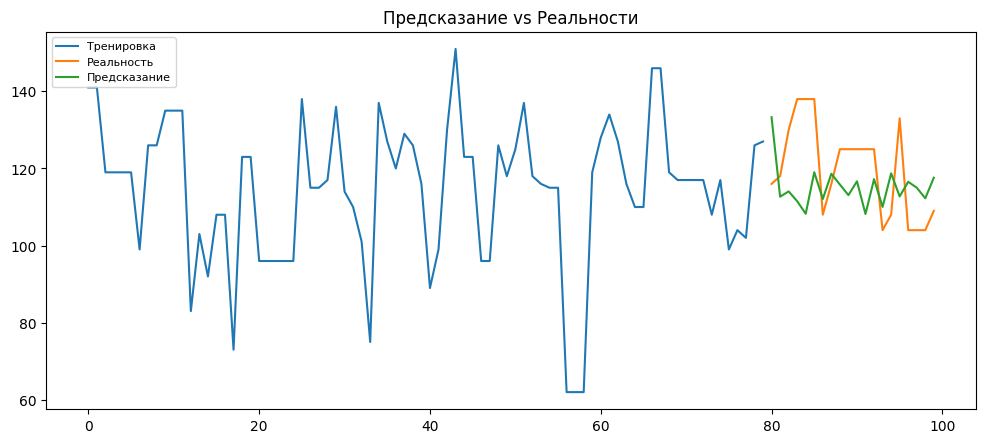

In [19]:
model = ARIMA(train1, order=(13, 1, 3))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(20, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test1.index)
lower_series = pd.Series(conf[:, 0], index=test1.index)
upper_series = pd.Series(conf[:, 1], index=test1.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train1, label='Тренировка')
plt.plot(test1, label='Реальность')
plt.plot(fc_series, label='Предсказание')
plt.title('Предсказание vs Реальности')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Кол-во машин

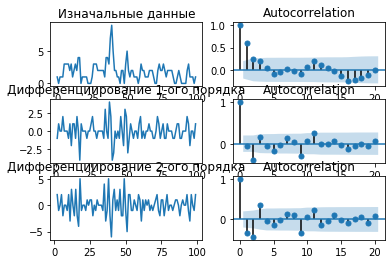

In [20]:
Y = new_traffic['Кол-во машин']

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(Y); axes[0, 0].set_title('Изначальные данные')
plot_acf(Y, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(Y.diff()); axes[1, 0].set_title('Дифференциирование 1-ого порядка')
plot_acf(Y.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(Y.diff().diff()); axes[2, 0].set_title('Дифференциирование 2-ого порядка')
plot_acf(Y.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [21]:
model = ARIMA(Y, order=(13,1,4))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:         D.Кол-во машин   No. Observations:                   99
Model:                ARIMA(13, 1, 4)   Log Likelihood                -143.706
Method:                       css-mle   S.D. of innovations              0.998
Date:                Fri, 12 Jul 2019   AIC                            325.412
Time:                        17:58:49   BIC                            374.719
Sample:                             1   HQIC                           345.361
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0041      0.036     -0.113      0.911      -0.075       0.067
ar.L1.D.Кол-во машин     -0.2914      0.128     -2.275      0.026      -0.543      -0.040
ar.L2.D.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


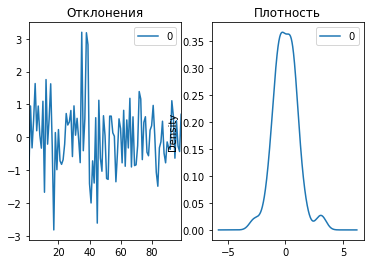

In [22]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Отклонения", ax=ax[0])
residuals.plot(kind='kde', title='Плотность', ax=ax[1])
plt.show()

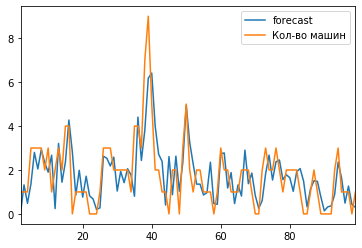

In [23]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [24]:
train2 = Y[:80]
test2 = Y[80:]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: Hessi

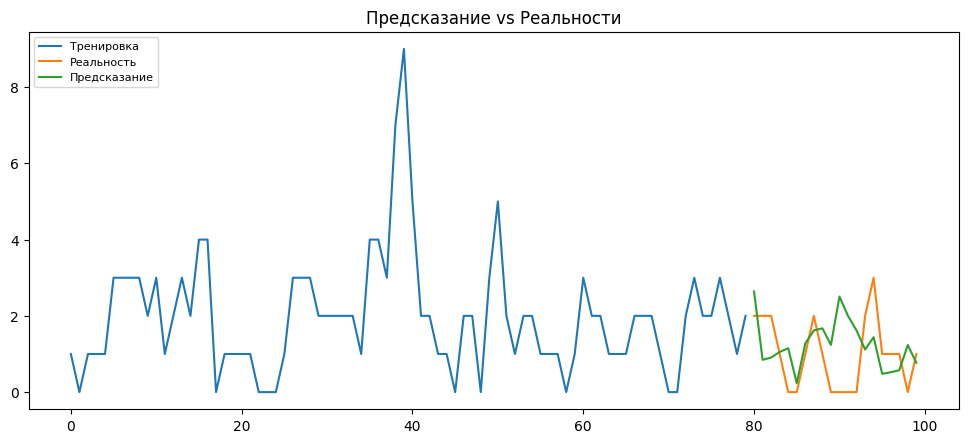

In [25]:
model = ARIMA(train2, order=(13, 1, 4))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(20, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test2.index)
lower_series = pd.Series(conf[:, 0], index=test2.index)
upper_series = pd.Series(conf[:, 1], index=test2.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train2, label='Тренировка')
plt.plot(test2, label='Реальность')
plt.plot(fc_series, label='Предсказание')
plt.title('Предсказание vs Реальности')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Средняя скорость

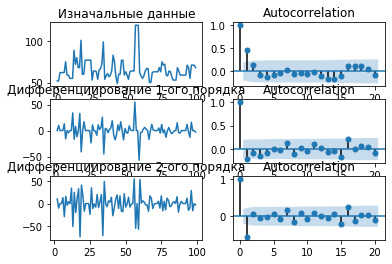

In [26]:
Z = new_traffic['Средняя скорость']

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(Z); axes[0, 0].set_title('Изначальные данные')
plot_acf(Z, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(Z.diff()); axes[1, 0].set_title('Дифференциирование 1-ого порядка')
plot_acf(Z.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(Z.diff().diff()); axes[2, 0].set_title('Дифференциирование 2-ого порядка')
plot_acf(Z.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [27]:
model = ARIMA(Z, order=(7,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:     D.Средняя скорость   No. Observations:                   99
Model:                 ARIMA(7, 1, 2)   Log Likelihood                -384.721
Method:                       css-mle   S.D. of innovations             11.548
Date:                Fri, 12 Jul 2019   AIC                            791.442
Time:                        17:59:45   BIC                            819.988
Sample:                             1   HQIC                           802.992
                                                                              
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.0261      0.064     -0.406      0.686      -0.152       0.100
ar.L1.D.Средняя скорость    -0.2121      0.331     -0.641      0.523      -0.861       0.

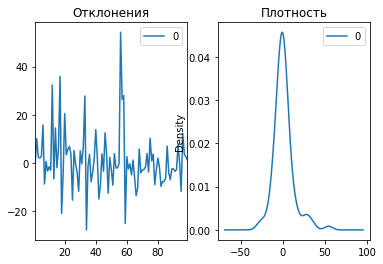

In [28]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Отклонения", ax=ax[0])
residuals.plot(kind='kde', title='Плотность', ax=ax[1])
plt.show()

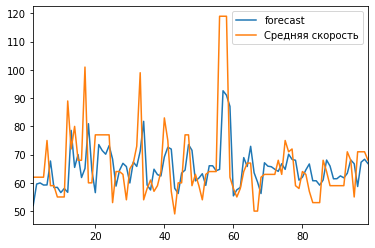

In [29]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [30]:
train3 = Z[:80]
test3 = Z[80:]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


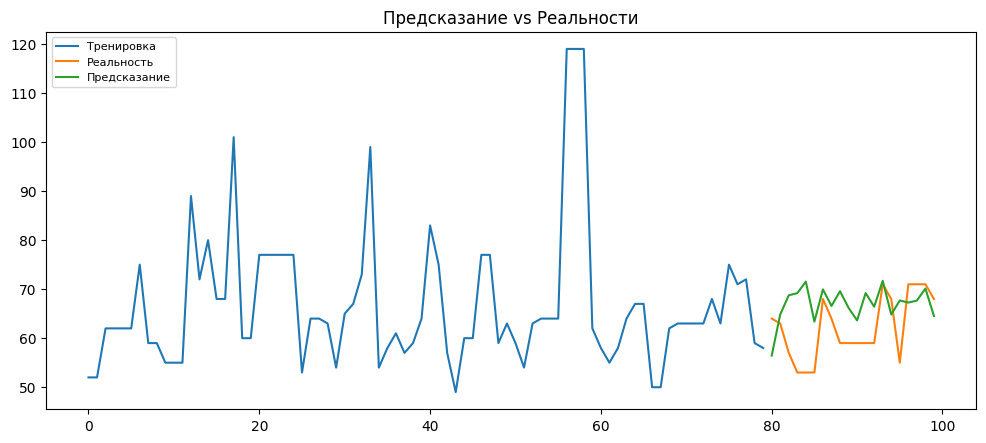

In [31]:
model = ARIMA(train3, order=(12, 1,5))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(20, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test3.index)
lower_series = pd.Series(conf[:, 0], index=test3.index)
upper_series = pd.Series(conf[:, 1], index=test3.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train3, label='Тренировка')
plt.plot(test3, label='Реальность')
plt.plot(fc_series, label='Предсказание')
plt.title('Предсказание vs Реальности')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Предсказания с использованием модели SARIMA

#### Среднее время

In [32]:
smodel = pm.auto_arima(X, start_p=1, start_q=1,test='adf',max_p=3, max_q=3, m=12,start_P=0, seasonal=True,
                         d=None, D=1, trace=True,error_action='ignore',  suppress_warnings=True, stepwise=True)

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=767.736, BIC=780.122, Fit time=1.596 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=836.796, BIC=841.750, Fit time=0.026 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=780.833, BIC=790.742, Fit time=0.520 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=769.049, BIC=778.958, Fit time=1.111 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=767.126, BIC=781.990, Fit time=2.113 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 0, 12); AIC=782.641, BIC=795.028, Fit time=0.754 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=769.023, BIC=786.364, Fit time=5.482 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=813.390, BIC=823.299, Fit time=0.571 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 1, 2, 12); AIC=770.284, BIC=790.103, Fit time=7.496 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 

In [33]:
print(smodel.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(1, 0, 0)x(1, 1, 1, 12)   Log Likelihood                -377.589
Date:                            Fri, 12 Jul 2019   AIC                            765.179
Time:                                    18:01:06   BIC                            777.566
Sample:                                         0   HQIC                           770.169
                                            - 100                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3432      0.809      0.424      0.671      -1.242       1.928
ar.L1          0.4362      0.100   

In [34]:
predict = smodel.fit_predict(train1, n_periods=20)

In [35]:
predict_series = pd.Series(predict, index=test1.index)

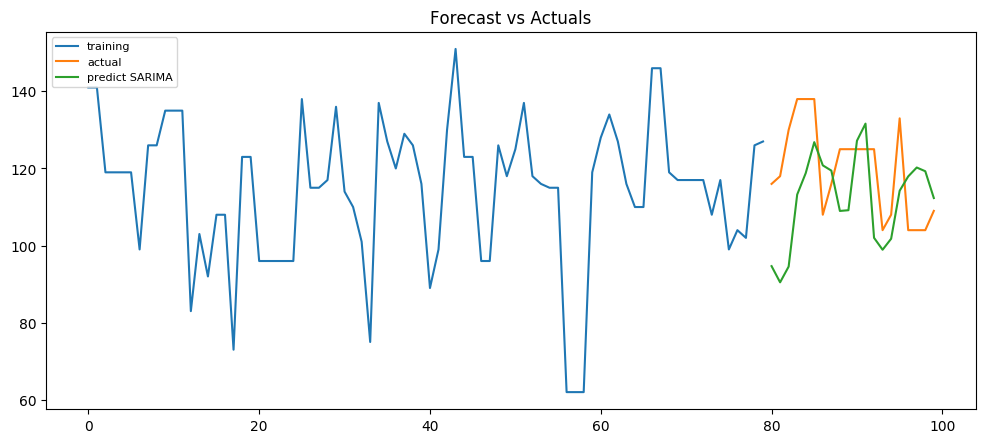

In [36]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train1, label='training')
plt.plot(test1, label='actual')
plt.plot(predict_series, label='predict SARIMA')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

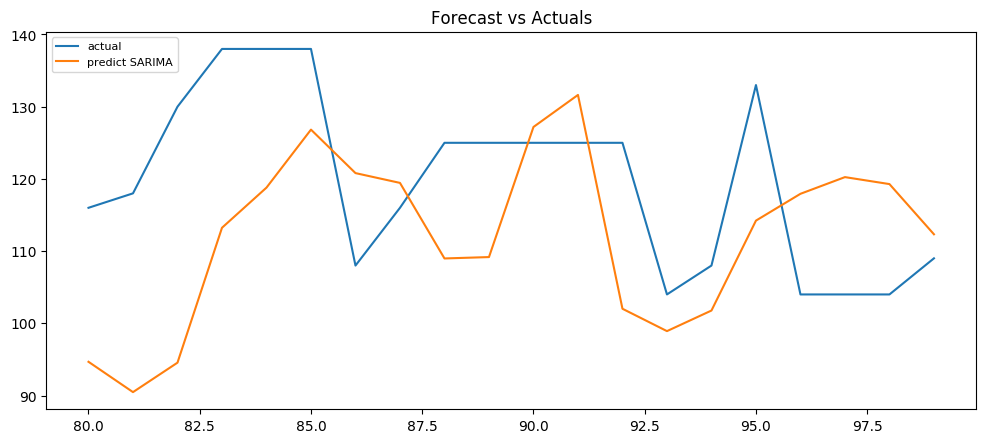

In [37]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test1, label='actual')
plt.plot(predict_series, label='predict SARIMA')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [38]:
forecast_accuracy(predict_series, test1.values)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


{'mape': 0.12311452317359892,
 'me': -7.523842935194639,
 'mae': 14.911348333573462,
 'mpe': -0.05445191034881751,
 'rmse': 17.25671900470921,
 'acf1': 0.32070728990771247,
 'corr': 0.11834134540398168,
 'minmax': 0.11946035420307288}

#### Кол-во машин

In [39]:
smodel = pm.auto_arima(Y, start_p=1, start_q=1,test='adf',max_p=3, max_q=3, m=12,start_P=0, seasonal=True,
                         d=None, D=1, trace=True,error_action='ignore',  suppress_warnings=True, stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=314.772, BIC=327.102, Fit time=1.932 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=364.735, BIC=369.667, Fit time=0.031 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=347.102, BIC=356.965, Fit time=0.313 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=325.746, BIC=335.610, Fit time=2.053 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=316.766, BIC=331.561, Fit time=3.489 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=348.851, BIC=358.714, Fit time=0.836 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=316.766, BIC=331.561, Fit time=5.185 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=318.773, BIC=336.034, Fit time=6.161 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=307.772, BIC=322.567, Fit time=1.800 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 

In [40]:
print(smodel.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 12)   Log Likelihood                -145.212
Date:                            Fri, 12 Jul 2019   AIC                            300.424
Time:                                    18:02:36   BIC                            312.754
Sample:                                         0   HQIC                           305.389
                                            - 100                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0114      0.008     -1.459      0.145      -0.027       0.004
ma.L1         -0.1934      3.565   

In [41]:
predict = smodel.fit_predict(train2, n_periods=20)

In [42]:
predict_series = pd.Series(predict, index=test2.index)

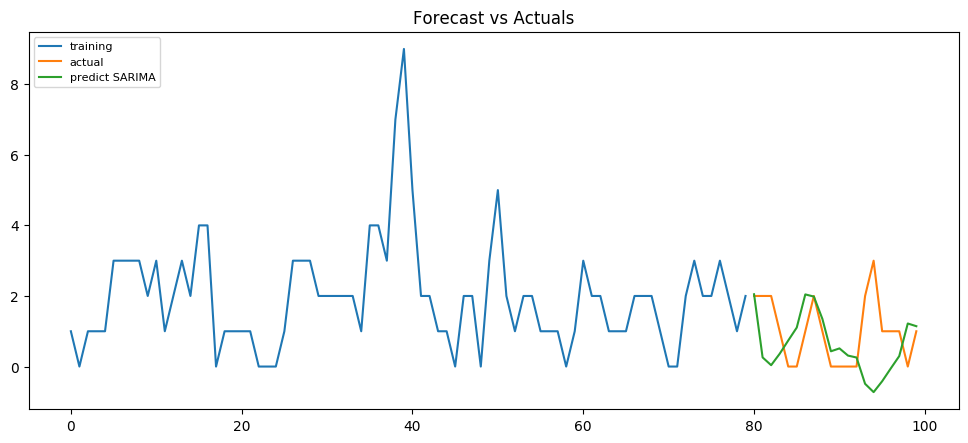

In [43]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train2, label='training')
plt.plot(test2, label='actual')
plt.plot(predict_series, label='predict SARIMA')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

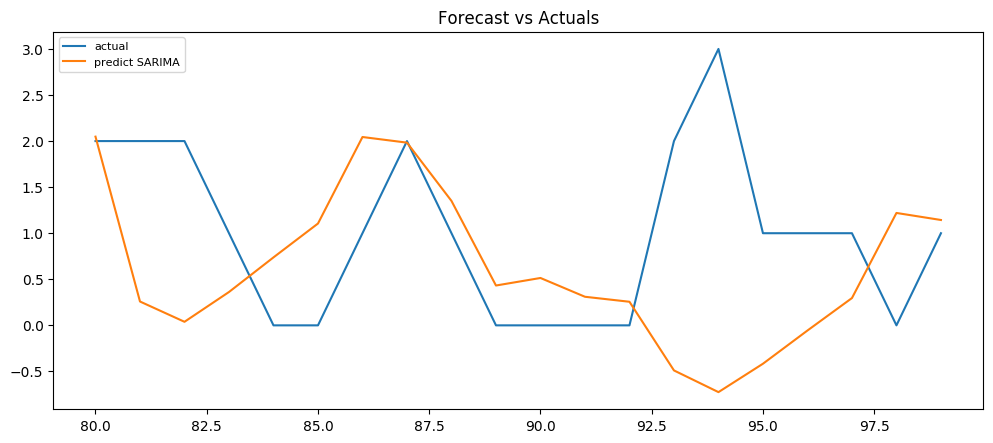

In [44]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test2, label='actual')
plt.plot(predict_series, label='predict SARIMA')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [45]:
forecast_accuracy(predict_series, test2.values)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


{'mape': inf,
 'me': -0.37928374707446294,
 'mae': 0.995485174020452,
 'mpe': inf,
 'rmse': 1.343041313734121,
 'acf1': 0.32070728990771247,
 'corr': -0.15257253902638915,
 'minmax': 0.8039757079369891}

#### Средняя скорость

In [46]:
smodel = pm.auto_arima(Z, start_p=1, start_q=1,test='adf',max_p=3, max_q=3, m=7,start_P=0, seasonal=True,
                         d=None, D=1, trace=True,error_action='ignore',  suppress_warnings=True, stepwise=True)

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 7); AIC=748.186, BIC=760.849, Fit time=0.784 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 7); AIC=814.058, BIC=819.124, Fit time=0.023 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 7); AIC=774.233, BIC=784.363, Fit time=0.495 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 7); AIC=749.664, BIC=759.794, Fit time=1.568 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 7); AIC=749.577, BIC=764.773, Fit time=1.063 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 7); AIC=787.956, BIC=798.086, Fit time=0.189 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 2, 7); AIC=749.434, BIC=764.629, Fit time=1.738 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 2, 7); AIC=750.071, BIC=767.800, Fit time=2.007 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 1, 7); AIC=748.562, BIC=763.758, Fit time=0.912 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 1, 7);

In [47]:
print(smodel.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                  100
Model:             SARIMAX(1, 0, 0)x(0, 1, 1, 7)   Log Likelihood                -369.732
Date:                           Fri, 12 Jul 2019   AIC                            747.464
Time:                                   18:02:53   BIC                            757.594
Sample:                                        0   HQIC                           751.554
                                           - 100                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0557      0.455     -0.122      0.903      -0.948       0.837
ar.L1          0.4971      0.057      8.769

In [48]:
predict = smodel.fit_predict(train3, n_periods=20)

In [49]:
predict_series = pd.Series(predict, index=test3.index)

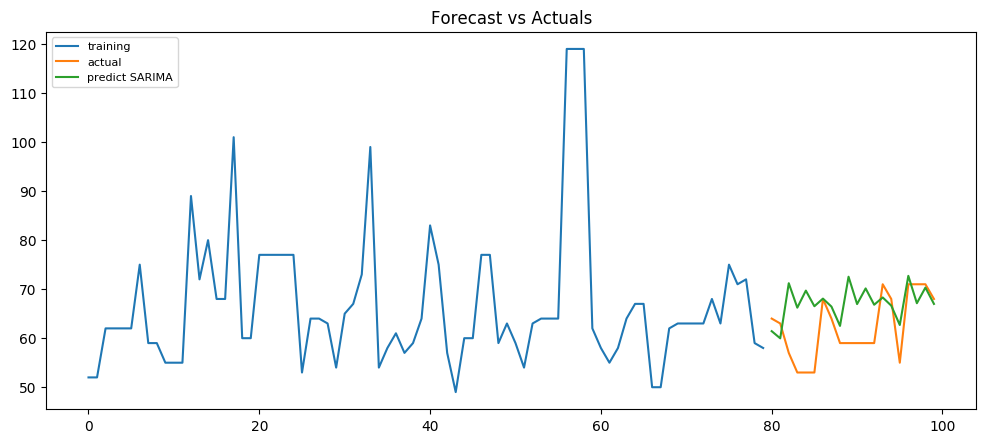

In [50]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train3, label='training')
plt.plot(test3, label='actual')
plt.plot(predict_series, label='predict SARIMA')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

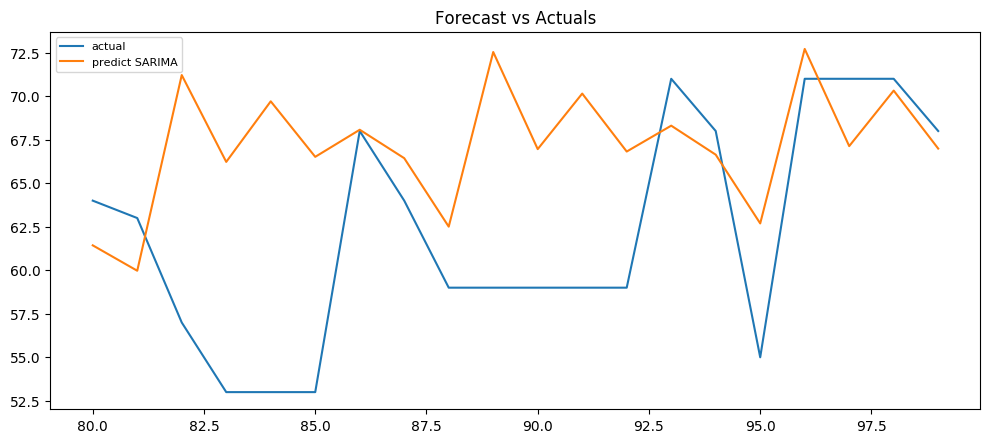

In [51]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test3, label='actual')
plt.plot(predict_series, label='predict SARIMA')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [52]:
forecast_accuracy(predict_series, test3.values)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


{'mape': 0.1121308410725749,
 'me': 4.917800994104801,
 'mae': 6.4378573883010315,
 'mpe': 0.08963745143817661,
 'rmse': 8.344260365429395,
 'acf1': 0.32070728990771247,
 'corr': 0.14494400572142063,
 'minmax': 0.0944379987083519}